In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

X = df_X.to_numpy()
y = df_y.values.ravel()

print(X.shape)

(100, 2834)


In [3]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import time
import numpy as np

def nested_cv_rfc(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Number of parameter settings that are sampled
    n_iter_search = 50
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=2)

    # Execute RandomizedSearchCV
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=inner_cv, verbose=1)

    # Using outer CV for assessing the performance
    outer_scores = cross_val_score(random_search, x_data, y_targets, cv=outer_cv, scoring=make_scorer(f1_score, average='micro'))

    print("Nested CV score (mean):", np.mean(outer_scores))

    # Refitting on the entire dataset (can be omitted if only interested in performance estimate)
    random_search.fit(x_data, y_targets)  # This line will be executed with the best parameters found in the inner CV
    best_params_random = random_search.best_params_
    
    # print("Best parameters from Random Search:", best_params_random)

    # # Defining a narrower search space for GridSearchCV around the best parameters found
    # param_grid = {
    #     "n_estimators": [best_params_random['n_estimators'] - 3, best_params_random['n_estimators'], best_params_random['n_estimators'] + 3],
    #     "max_leaf_nodes": [best_params_random['max_leaf_nodes'] - 5, best_params_random['max_leaf_nodes'], best_params_random['max_leaf_nodes'] + 5],
    #     "max_depth": [best_params_random['max_depth'] - 5, best_params_random['max_depth'], best_params_random['max_depth'] + 5],
    #     "min_samples_split": [best_params_random['min_samples_split'] - 3, best_params_random['min_samples_split'], best_params_random['min_samples_split'] + 3],
    #     "max_features": [max(1, best_params_random['max_features'] - 3), best_params_random['max_features'], best_params_random['max_features'] + 4]
    # }

    # # Ensure parameters are within the original bounds
    # for key in param_grid.keys():
    #     param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]

    # grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=inner_cv, verbose=1)
    # grid_search.fit(x_data, y_targets)
    # best_params_grid = grid_search.best_params_

    # print("Best parameters from Grid Search:", best_params_grid)

    return best_params_random

# Usage: best_params = nested_cv_rfc(x_data, y_targets)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [19]:
m_rf = RandomForestClassifier(n_estimators = 20, max_features = 3, random_state=42).fit(X_train, y_train)
y_pred_std = m_rf.predict(X_test)

print(classification_report(y_test, y_pred_std, zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.62      0.53        13
           1       0.17      0.12      0.14         8
           2       0.29      0.22      0.25         9

    accuracy                           0.37        30
   macro avg       0.31      0.32      0.31        30
weighted avg       0.33      0.37      0.34        30



In [6]:
best_params = nested_cv_rfc(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Nested CV score (mean): 0.7285714285714285
Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [21]:
m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.42      0.62      0.50         8
           2       0.50      0.44      0.47         9

    accuracy                           0.53        30
   macro avg       0.54      0.54      0.53        30
weighted avg       0.56      0.53      0.54        30



In [22]:
def feature_importance(model, X_train):

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create generic feature names if not already provided
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"{i}" for i in range(X_train.shape[1])]

    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(feature_importances)[::-1]

    # Select the top 50 features
    top_indices = indices[:100]
    
    # Adjust the size of the plot to accommodate 50 features nicely
    plt.figure(figsize=(15, 10))
    plt.title("Top 50 Feature Importances")
    plt.bar(range(100), feature_importances[top_indices], color="r", align="center")
    
    # Set the ticks to be the names of the top 50 features
    plt.xticks(range(100), [feature_names[i] for i in top_indices], rotation=90)
    plt.xlim([-1, 100])
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

    return top_indices

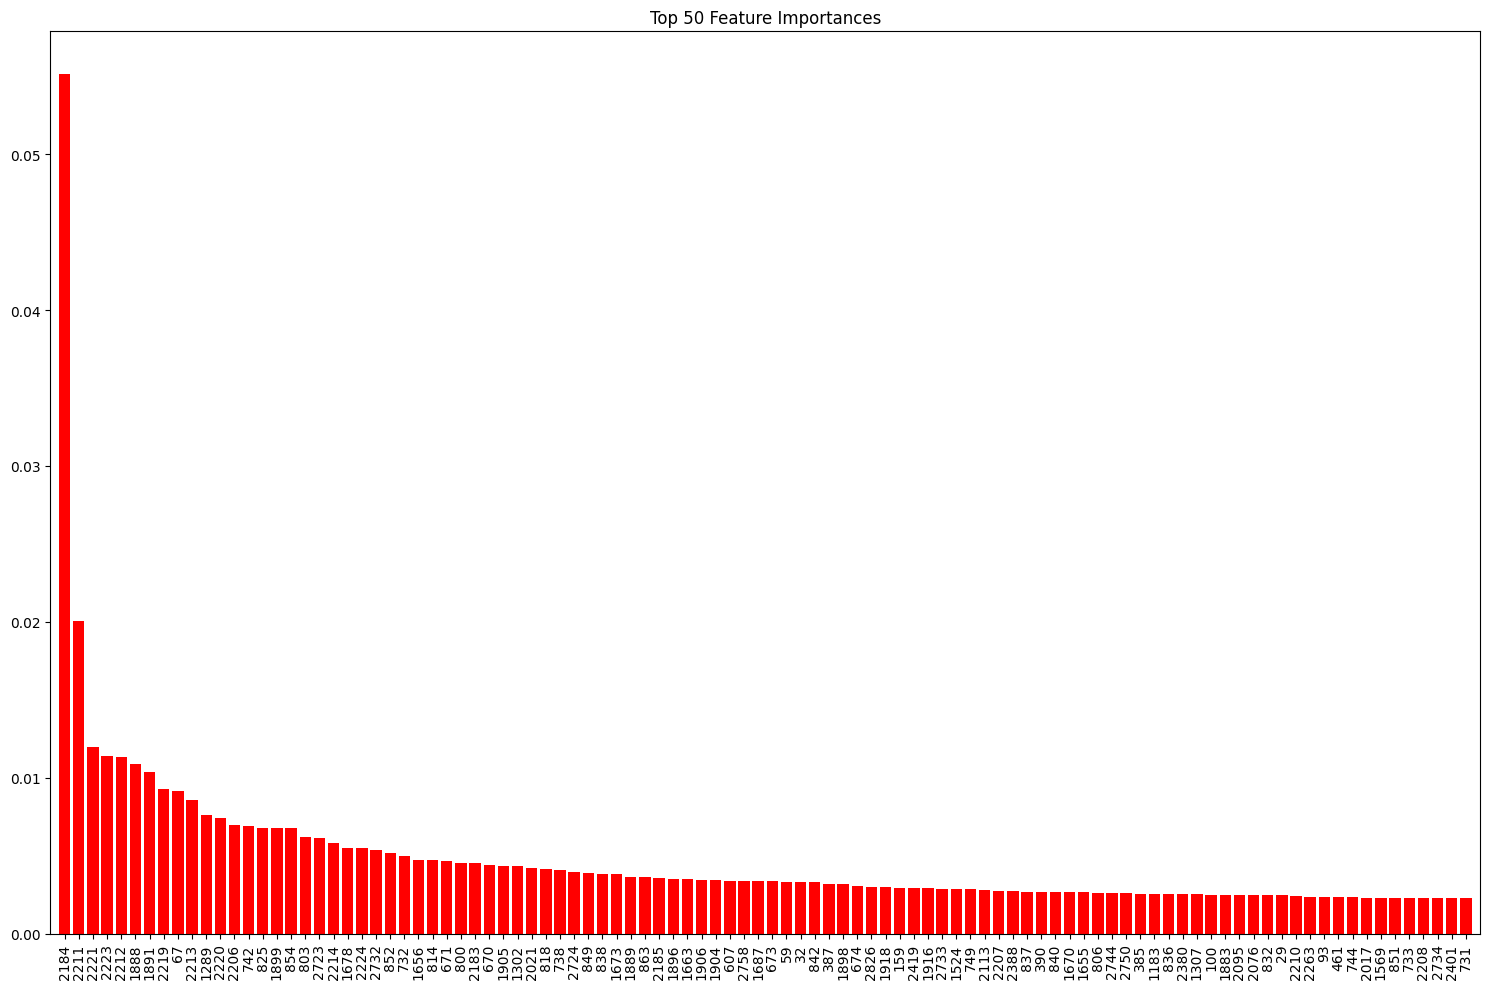

In [28]:
top_features_rf = feature_importance(m_rf_optimized, X_train)

In [24]:
print(top_features_rf)

top_features_l1 = [174, 189, 192, 229, 230, 261, 385, 623, 671, 744, 745, 761, 765, 771, 791, 800, 818, 851, 854, 857, 888, 1065, 1087, 1160, 1243, 1302, 1303, 1306, 1559, 1656, 1663, 1679, 1788, 1895, 1898, 1902, 1910, 1994, 2017, 2026, 2058, 2130, 2184, 2206, 2207, 2212, 2213, 2218, 2221, 2382, 2547, 2549, 2662, 2723, 2732, 2742, 2776, 2789, 2791, 2817, 2818]

[ 802 2723 2025  868 1681  850 2679 1651 2240 2366  131 2078 2074  855
 2557  912 1666 1891  140  755 2089 2725 2420 1294  671  890 1065 2716
 2477 1447   69 2355 1901 2218 2379 2194 1572 1448  272  500  154  398
 1953 1902  819 1549 1636 2272  635  861 2113 1662  148 2394  169  864
  480   68 1840  614  195 2108 1475 2798 2295  116  812 1081 2832 2039
 2380 1627 2286  712 2667  317 1122 2232 1536  621 2262 2773 1047 2709
 2158 2726 2009 2111  779   34 2186 2236 2739  342 2711 2754 2770  842
 2417 2655]


In [25]:
def calculate_similarity(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    # Calculate intersection and union
    intersection = set1 & set2
    union = set1 | set2
    
    # Calculate Jaccard similarity index
    if len(union) == 0:  # Prevent division by zero
        similarity = 0
    else:
        similarity = len(intersection) / len(union)
    
    return similarity, list(intersection)

# Example usage:
list_a = [1, 2, 3, 4, 5]
list_b = [4, 5, 6, 7, 8]

similarity, intersection = calculate_similarity(list_a, list_b)
print("Similarity index:", similarity)
print("Intersection of lists:", intersection)


Similarity index: 0.25
Intersection of lists: [4, 5]


In [29]:
calculate_similarity(top_features_rf, top_features_l1)

(0.14184397163120568,
 [385,
  2184,
  1302,
  2206,
  2207,
  800,
  671,
  2723,
  2212,
  2213,
  2732,
  2221,
  818,
  851,
  854,
  2017,
  744,
  1898,
  1656,
  1663])